# 1. Loading documents

You can modify how the `SimpleKGBuilder` loads documents to suit your own use case.

You may want to:

- Load documents from a custom source, such as a database or an API.

- Pre-process documents before they are loaded, such as removing unwanted text or formatting.

- Implement custom parsing logic for specific document types.

In this lesson you will explore examples of how to create custom document loaders.

## Custom PDF Loader

You can extend the existing PDF loader to fit your own use case, such as pre-processing the text before it is loaded into the graph.

The PDF documents you have been using in this course contain `:attributes:` that are not relevant to the knowledge graphs and may introduce noise.

```
= What is Generative AI
:order: 1
:type: lesson
:slides: true

...
```

You can strip the attributes from the text before it is loaded into the graph by extending the [PdfLoader](https://neo4j.com/docs/neo4j-graphrag-python/current/api.html?_gl=1*8h6szi*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DL38Q8KGQC*czE3NjUwNjk4NzYkbzU3JGcxJHQxNzY1MDg5NDU5JGo2MCRsMCRoMA..*_ga_DZP8Z65KK4*czE3NjUwNjk4NzYkbzU3JGcxJHQxNzY1MDg5NDU5JGo2MCRsMCRoMA..#pdfloader) class to create a `CustomPDFLoader`

```python
from neo4j_graphrag.experimental.components.pdf_loader import PdfLoader, PdfDocument

import re
from fsspec import AbstractFileSystem
from typing import Dict, Optional, Union
from pathlib import Path

class CustomPDFLoader(PdfLoader):
    async def run(
        self,
        filepath: Union[str, Path],
        metadata: Optional[Dict[str, str]] = None,
        fs: Optional[Union[AbstractFileSystem, str]] = None,
    ) -> PdfDocument:
        pdf_document = await super().run(filepath, metadata, fs)

        # Process the PDF document
        # remove asciidoc attribute lines like :id:
        pdf_document.text = re.sub(r':*:.*\n?', '', pdf_document.text, flags=re.MULTILINE)

        return pdf_document

data_loader = CustomPDFLoader()
```

The `CustomPDFLoader` overrides the run method to pre-process the text and uses regex to remove unwanted attributes.

You can run the custom loader directly to verify that it is working:

```python
pdf_file = "./genai-graphrag-python/data/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf"
doc = asyncio.run(data_loader.run(pdf_file))
print(doc.text)
```

The custom loader can then be used in the SimpleKGPipeline to load and process PDF documents by setting the `pdf_loader` parameter:

```pytthon
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    pdf_loader=data_loader
)
```

## Custom Data Loader

The `SimpleKGPipeline` can load documents from different sources by implementing a custom data loader.

You can extend the [DataLoader](https://neo4j.com/docs/neo4j-graphrag-python/current/api.html?_gl=1*1gn6h08*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DL38Q8KGQC*czE3NjUwNjk4NzYkbzU3JGcxJHQxNzY1MDg5NDU5JGo2MCRsMCRoMA..*_ga_DZP8Z65KK4*czE3NjUwNjk4NzYkbzU3JGcxJHQxNzY1MDg5NDU5JGo2MCRsMCRoMA..#dataloader) a class to load any text data from any source.

You can load data from a text file by implementing a `TextLoader` class:

```python
from neo4j_graphrag.experimental.components.pdf_loader import DataLoader, PdfDocument, DocumentInfo
from pathlib import Path

class TextLoader(DataLoader):
    async def run(self, filepath: Path) -> PdfDocument:

        # Process the file
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Return a PdfDocument
        return PdfDocument(
            text=text,
            document_info=DocumentInfo(
                path=str(filepath),
                metadata={}
            )
        )
    
data_loader = TextLoader()
```

```python
import os
from dotenv import load_dotenv
load_dotenv()

import asyncio

from neo4j import GraphDatabase
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

from neo4j_graphrag.experimental.components.pdf_loader import DataLoader, PdfDocument, DocumentInfo
from pathlib import Path

neo4j_driver = GraphDatabase.driver(
    os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)
neo4j_driver.verify_connectivity()

llm = OpenAILLM(
    model_name="gpt-4o",
    model_params={
        "temperature": 0,
        "response_format": {"type": "json_object"},
    }
)

embedder = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

class TextLoader(DataLoader):
    async def run(self, filepath: Path) -> PdfDocument:

        # Process the file
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Return a PdfDocument
        return PdfDocument(
            text=text,
            document_info=DocumentInfo(
                path=str(filepath),
                metadata={}
            )
        )
    
data_loader = TextLoader()

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    pdf_loader=data_loader
)

pdf_file = "./genai-graphrag-python/data/genai-fundamentals_1-generative-ai_1-what-is-genai.txt"
doc = asyncio.run(data_loader.run(pdf_file))
print(doc.text)

print(f"Processing {pdf_file}")
result = asyncio.run(kg_builder.run_async(file_path=pdf_file))
print(result.result)
```

# 2. Splitting text into chunks

You can modify how the `SimpleKGBuilder` splits text into chunks. Your strategy for splitting text will impact the construction and how you search the knowledge graph.

In this lesson you will learn how to create a custom text splitter or integrate with an existing [LangChain text splitter](https://python.langchain.com/docs/concepts/text_splitters/).

## Custom Text Splitter

A custom text splitter allows you to define how the text is divided into chunks.

The PDF documents you have been using in this course contain sections, for example = Heading and == `Subheading`, that can be used to logically split the text into meaningful chunks. Example:

```
= What is Generative AI

== GenAI

Generative AI (or GenAI) refers to artificial intelligence systems ...

== Large Language Models (LLMs)

LLMs are a type of generative AI model designed to understand and generate human-like text ...
```

You can create a custom text splitter by extending the [TextSplitter](https://neo4j.com/docs/neo4j-graphrag-python/current/api.html?_gl=1*11tx9gs*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk3MjE5JGo1OSRsMCRoMA..*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk3MjE5JGo1OSRsMCRoMA..#textsplitter) class:

```python
from neo4j_graphrag.experimental.components.text_splitters.base import TextSplitter
from neo4j_graphrag.experimental.components.types import TextChunk, TextChunks

class SectionSplitter(TextSplitter):
    def __init__(self, section_heading: str = "== ") -> None:
        self.section_heading = section_heading

    async def run(self, text: str) -> TextChunks:
        index = 0
        chunks = []
        current_section = ""

        for line in text.split('\n'):
            # Does the line start with the section heading?
            if line.startswith(self.section_heading):
                chunks.append(
                    TextChunk(text=current_section, index=index)
                )
                current_section = ""
                index += 1
            
            current_section += line + "\n"

        # Add the last section
        chunks.append(
            TextChunk(text=current_section, index=index)
        )
        
        return TextChunks(chunks=chunks)

splitter = SectionSplitter()
```

The `SectionSplitter` class splits the text based on a section heading (== ), then creates `TextChunk` objects for each section, and finally returns a `TextChunks` object containing all the chunks.

You can run the text splitter directly with test data to verify that it is working:

```python
text = """
= Heading 1
This is the main section

== Sub-heading
This is some text.

== Sub-heading 2
This is some more text.
"""

chunks = asyncio.run(splitter.run(text))
print(chunks)
```

Your text splitter can then be used in the `SimpleKGPipeline` to split text into chunks by setting the `text_splitter` parameter:

```python
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder,
    from_pdf=True,
    text_splitter=splitter,
)
```

## Integrate with LangChain Text Splitters

LangChain provides a variety of [text splitters](https://python.langchain.com/docs/concepts/text_splitters/) that you can use to implement different chunking strategies.

The `neo4j_graphrag` package includes a `LangChainTextSplitterAdapter` class that allows you to integrate LangChain text splitters with the `SimpleKGBuilder`.

You can use the [LangChain](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.CharacterTextSplitter.html) `CharacterTextSplitter` to split text into paragraphs.

```python
# You will need to install langchain-text-splitters: pip install langchain-text-splitters
from neo4j_graphrag.experimental.components.text_splitters.langchain import LangChainTextSplitterAdapter
from langchain_text_splitters import CharacterTextSplitter

splitter = LangChainTextSplitterAdapter(
    CharacterTextSplitter(
        separator="\n\n",
        chunk_size=500,
        chunk_overlap=100,
    )
)
```

The `LangChainTextSplitterAdapter` wraps the LangChain `CharacterTextSplitter` to create text chunks.

The LangChain text splitter can then be used in the `SimpleKGPipeline` to split text into chunks by setting the `text_splitter` parameter:

```python
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder,
    from_pdf=True,
    text_splitter=splitter,
)
```

Full code:

```python
import os
from dotenv import load_dotenv
load_dotenv()

import asyncio

from neo4j import GraphDatabase
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

# You will need to install langchain-text-splitters: pip install langchain-text-splitters
from neo4j_graphrag.experimental.components.text_splitters.langchain import LangChainTextSplitterAdapter
from langchain_text_splitters import CharacterTextSplitter

neo4j_driver = GraphDatabase.driver(
    os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)
neo4j_driver.verify_connectivity()

llm = OpenAILLM(
    model_name="gpt-4o",
    model_params={
        "temperature": 0,
        "response_format": {"type": "json_object"},
    }
)

embedder = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

splitter = LangChainTextSplitterAdapter(
    CharacterTextSplitter(
        separator="\n\n",
        chunk_size=500,
        chunk_overlap=100,
    )
)

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder,
    from_pdf=True,
    text_splitter=splitter,
)

pdf_file = "./genai-graphrag-python/data/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf"

print(f"Processing {pdf_file}")
result = asyncio.run(kg_builder.run_async(file_path=pdf_file))
print(result.result)
```

# 3. Lexical graph configuration

The `SimpleKGBuilder` uses a default unstructured graph data model to represent documents, text chunks, and entities.

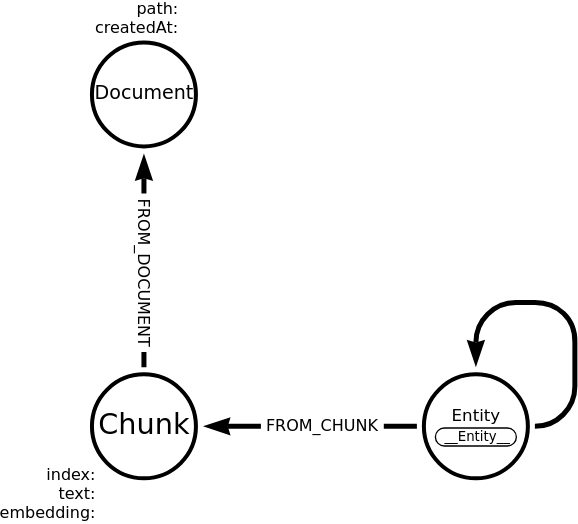

You can modify this data model to suit your own use case by creating a [LexicalGraphConfig](https://neo4j.com/docs/neo4j-graphrag-python/current/types.html?_gl=1*1vabf2e*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MDQ5JGo1OSRsMCRoMA..*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MDQ5JGo1OSRsMCRoMA..#lexicalgraphconfig).

## Create Lexical Graph Configuration

The documents you have been using contain lessons which can be sub-divided into sections.

An alternative graph data model could represent each document as a `Lesson` node, with `Section` nodes representing each chunks within the text.

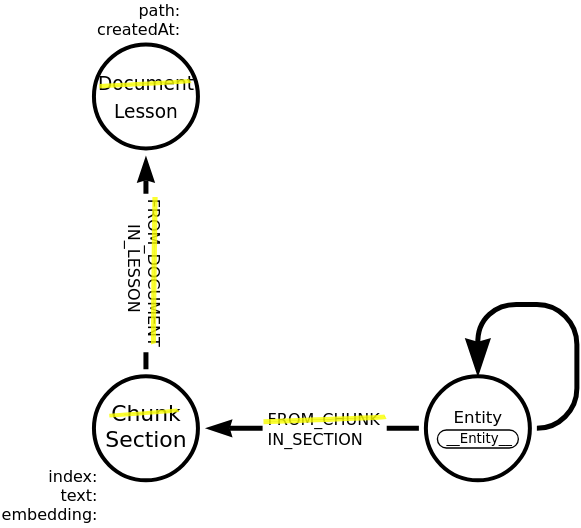

To create this graph data model you can define a custom `LexicalGraphConfig`:

```python
from neo4j_graphrag.experimental.components.types import LexicalGraphConfig

config = LexicalGraphConfig(
    chunk_node_label="Section",
    document_node_label="Lesson",
    chunk_to_document_relationship_type="IN_LESSON",
    next_chunk_relationship_type="NEXT_SECTION",
    node_to_chunk_relationship_type="IN_SECTION",
    chunk_embedding_property="embeddings",
)
```

The `config` object defines the mapping between the documents, chunks, and entities nodes.

You can then use the custom configuration in the `SimpleKGPipeline` by setting the `lexical_graph_config` parameter:

```python
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    lexical_graph_config=config,
)
```

Full code:

```python
import os
from dotenv import load_dotenv
load_dotenv()

import asyncio

from neo4j import GraphDatabase
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

from neo4j_graphrag.experimental.components.types import LexicalGraphConfig

neo4j_driver = GraphDatabase.driver(
    os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)
neo4j_driver.verify_connectivity()

llm = OpenAILLM(
    model_name="gpt-4o",
    model_params={
        "temperature": 0,
        "response_format": {"type": "json_object"},
    }
)

embedder = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

config = LexicalGraphConfig(
    chunk_node_label="Section",
    document_node_label="Lesson",
    chunk_to_document_relationship_type="IN_LESSON",
    next_chunk_relationship_type="NEXT_SECTION",
    node_to_chunk_relationship_type="IN_SECTION",
    chunk_embedding_property="embeddings",
)

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    lexical_graph_config=config,
)

pdf_file = "./genai-graphrag-python/data/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf"
result = asyncio.run(kg_builder.run_async(file_path=pdf_file))
print(result.result)
```

# Entity resolution

When the entities are identified in the text and subsequently created in the knowledge graph, they may not be unique. For example, the text may refer to Neo4j in some places and `Neo4j Graph Database` in others.

The default entity resolution strategy in the `SimpleKGBuilder` is to merge entities that have the same label and identical name property.

## No Entity Resolution

You can disable entity resolution by setting the `perform_entity_resolution` parameter to `False` when creating the `SimpleKGBuilder` instance:

```python
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    perform_entity_resolution=False,
)
```

Disabling entity resolution will result in all identified entities being created as new nodes.

**Multiple nodes for the same entity**

This may lead to multiple nodes representing the same real-world entity.

## Post Processing Entity Resolution
The `neo4j_graphrag` library includes additional [entity resolver components](https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html?_gl=1*16ra8n6*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..#entity-resolver). The entity resolvers are used after the creation of the knowledge graph to identify and merge duplicate entities.

For example:

- The [SpacySemanticMatchResolver](https://neo4j.com/docs/neo4j-graphrag-python/current/api.html?_gl=1*1b6o1rw*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..#spacysemanticmatchresolver) uses the [spaCy](https://spacy.io/) library to find and resolve entities with the same label and similar set of textual properties.

- The [FuzzyMatchResolver](https://neo4j.com/docs/neo4j-graphrag-python/current/api.html?_gl=1*1b6o1rw*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..#fuzzymatchresolver) finds and resolves entities with the same label and similar set of textual properties using [RapidFuzz](https://rapidfuzz.github.io/RapidFuzz/) for fuzzy matching.

Post processing of entities can result in a more concise knowledge graph with fewer duplicate entities but with the risk of incorrectly merging distinct entities.

Refer to the [Entity Resolver documentation](https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html?_gl=1*o1tzys*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MDk4MzI3JGo2MCRsMCRoMA..#entity-resolver) for more information and how to use them.

When you’re ready you can continue.

# LLM configuration

You can modify which large language model (LLM) you use to suit your own needs.

You may want to:

- Use a different LLM provider for cost or feature reasons.

- Adjust model parameters to control the output.

- Run a local LLM for data privacy or latency reasons.

- Modify the prompt to cater to your specific domain.

## LLM Provider

The LLM you use is configurable in the `SimpleKGPipeline` via the llm parameter.

The neo4j_graphrag package includes [adapters for several popular LLM providers](https://neo4j.com/docs/neo4j-graphrag-python/current/api.html?_gl=1*1vh9c1c*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MTAwMjM4JGo2MCRsMCRoMA..*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MTAwMjM4JGo2MCRsMCRoMA..#openaillm), including OpenAI, Azure OpenAI, and Ollama.

For example, you could run the OpenAI open source model [openai/gpt-oss-20b](https://huggingface.co/openai/gpt-oss-20b) locally using a application such as [LM Studio](https://lmstudio.ai/):

```python
llm = OpenAILLM(
    model_name="openai/gpt-oss-20b",
    model_params={
       "temperature": 0
    },
    base_url = "http://localhost:1234/v1"
)
```

**Model parameters**

Through `model_params` you can change how the model responds by adjusting model parameters such as `temperature` and `response_format`.

The parameters available will depend on the specific LLM you are using.

You can also create your own LLM adapter by inheriting from the [LLMInterface](https://neo4j.com/docs/neo4j-graphrag-python/current/api.html?_gl=1*1b34wjn*_ga*MTkzMzgxNTk1LjE3NTcyNTg0MzQ.*_ga_DZP8Z65KK4*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MTAwMjM4JGo2MCRsMCRoMA..*_gcl_au*MTMzNzk5ODY4OS4xNzY1MDY5ODc4*_ga_DL38Q8KGQC*czE3NjUwOTcyMTgkbzU4JGcxJHQxNzY1MTAwMjM4JGo2MCRsMCRoMA..#llminterface) class.

## Prompt Customization

The prompt used for entity extraction and other tasks can also be customized by modifying the `prompt_template` parameter of the `SimpleKGPipeline`.

You can provide an entirely new prompt, but it is often easier to add to the existing.

If you wanted to restrict entity extraction to a specific domain, such as technology companies, you could modify the prompt as follows:

```python
from neo4j_graphrag.generation.prompts import ERExtractionTemplate

domain_instructions = (
    "Only extract entities that are related to the technology industry."
    "These include companies, products, programming languages, frameworks, and tools."
    "\n"
)

prompt_template = ERExtractionTemplate(
    template = domain_instructions + ERExtractionTemplate.DEFAULT_TEMPLATE 
)
```

The domain_instructions are added to the start of the default entity extraction prompt to guide the LLM to only extract relevant entities.

The custom prompt can then be used in the `SimpleKGPipeline` by setting the prompt_template parameter:

```python
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    prompt_template=prompt_template,
)
```

Full code:

```python
import os
from dotenv import load_dotenv
load_dotenv()

import asyncio

from neo4j import GraphDatabase
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

from neo4j_graphrag.generation.prompts import ERExtractionTemplate

neo4j_driver = GraphDatabase.driver(
    os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)
neo4j_driver.verify_connectivity()

llm = OpenAILLM(
    model_name="gpt-4o",
    model_params={
        "temperature": 0,
        "response_format": {"type": "json_object"},
    }
)

embedder = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

domain_instructions = (
    "Only extract entities that are related to the technology industry."
    "These include companies, products, programming languages, frameworks, and tools."
    "\n"
)

prompt_template = ERExtractionTemplate(
    template = domain_instructions + ERExtractionTemplate.DEFAULT_TEMPLATE 
)

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    prompt_template=prompt_template,
)

pdf_file = "./genai-graphrag-python/data/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf"
result = asyncio.run(kg_builder.run_async(file_path=pdf_file))
print(result.result)
```